In [8]:
!pip install pandas

In [9]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [10]:
!pip install ultralytics

In [11]:
!pip install -U ipywidgets

In [12]:
dataset_path = '/kaggle/input/car-plate-detection'

## Setting up dataset path

In [13]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

# Example usage
print(the_number_in_the_string("file123.txt"))  # Output: 123
print(the_number_in_the_string("no_numbers_here"))  # Output: 0

123
0


## Formatting the xml file and creating DF

In [14]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob

# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()
    
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



In [16]:
import os
import shutil
import pandas as pd

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [17]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [18]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [19]:
os.getcwd()

'/kaggle/working'

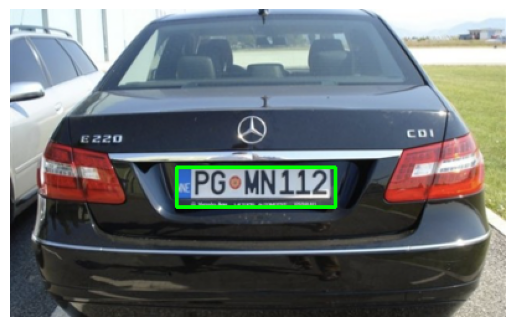

In [20]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [21]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [22]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 354MB/s]


In [23]:
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=32,               # Optimized batch size for GPU memory
    device='cuda',          # Use GPU for training
    imgsz=320,              # Start with smaller images
    cache='ram',            # Cache dataset in RAM
    lr0=0.01,               # Initial learning rate
    optimizer='AdamW',      # Optimizer with weight decay
    dropout=0.3,            # Dropout for regularization
    amp=True,               # Mixed precision for faster training
    warmup_epochs=3         # Warm-up phase for stable training
)

Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=ram, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 83.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 309MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 469.47it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 201.67it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 531.11it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 122.44it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.19G      2.033      3.601      1.488         49        320: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         44         44    0.00303      0.909      0.322       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.15G      1.769      1.814      1.362         53        320: 100%|██████████| 11/11 [00:01<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         44         44   0.000682      0.159   0.000668   0.000192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.15G      1.785      1.506      1.406         51        320: 100%|██████████| 11/11 [00:01<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         44         44    0.00952     0.0227   0.000402   0.000229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.15G      1.826      1.374      1.491         49        320: 100%|██████████| 11/11 [00:01<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         44         44    0.00039      0.114   0.000365   6.06e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.16G       1.84      1.394      1.519         44        320: 100%|██████████| 11/11 [00:01<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         44         44   0.000383      0.114   0.000211   3.33e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.17G      1.801      1.277      1.557         52        320: 100%|██████████| 11/11 [00:01<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         44         44    0.00323      0.205    0.00184   0.000655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.16G      1.746       1.26      1.458         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

                   all         44         44       0.52      0.295      0.263     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.17G       1.76      1.257      1.437         57        320: 100%|██████████| 11/11 [00:01<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         44         44      0.539      0.273      0.281      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.16G      1.709      1.172      1.425         49        320: 100%|██████████| 11/11 [00:01<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         44         44      0.238      0.114     0.0848     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.17G      1.667      1.192        1.4         55        320: 100%|██████████| 11/11 [00:01<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         44         44     0.0479     0.0455     0.0143    0.00188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.16G      1.629       1.15      1.392         54        320: 100%|██████████| 11/11 [00:01<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         44         44     0.0013     0.0909   0.000956   0.000289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.17G      1.743      1.217      1.452         49        320: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         44         44      0.183     0.0455      0.051     0.0054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.16G      1.676      1.172      1.399         51        320: 100%|██████████| 11/11 [00:01<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         44         44      0.393      0.205       0.16     0.0481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.17G      1.624      1.121      1.363         42        320: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         44         44      0.479      0.455      0.406      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.16G      1.575      1.086      1.354         43        320: 100%|██████████| 11/11 [00:01<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         44         44       0.61      0.455       0.49      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.17G      1.628      1.084      1.389         46        320: 100%|██████████| 11/11 [00:01<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         44         44      0.512      0.597      0.532      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.16G       1.55      1.072      1.356         50        320: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         44         44      0.449      0.432      0.421      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.17G       1.52      1.033      1.296         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         44         44       0.66        0.5      0.552      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.16G      1.596       1.05      1.377         45        320: 100%|██████████| 11/11 [00:01<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         44         44      0.885      0.701      0.824      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.17G      1.548      1.011      1.298         46        320: 100%|██████████| 11/11 [00:01<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         44         44      0.825      0.682      0.769      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.16G      1.575      1.052      1.362         51        320: 100%|██████████| 11/11 [00:01<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         44         44      0.745       0.75      0.781      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.17G      1.562      1.044      1.333         55        320: 100%|██████████| 11/11 [00:01<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         44         44      0.614      0.636      0.664      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.16G      1.523      1.021      1.324         49        320: 100%|██████████| 11/11 [00:01<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         44         44      0.668      0.659      0.702      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.17G      1.539       1.01      1.314         42        320: 100%|██████████| 11/11 [00:01<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         44         44      0.653      0.659      0.654      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.16G      1.504      1.012      1.295         52        320: 100%|██████████| 11/11 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         44         44      0.733      0.705      0.749      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.17G      1.502     0.9469      1.258         44        320: 100%|██████████| 11/11 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         44         44      0.735      0.568      0.566      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.16G      1.448     0.9055      1.253         55        320: 100%|██████████| 11/11 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         44         44      0.687       0.75      0.715      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.17G      1.508     0.9509      1.294         45        320: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         44         44      0.827      0.763      0.845      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.16G      1.431     0.9006      1.252         54        320: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         44         44      0.821      0.795      0.839      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.17G      1.404     0.9148      1.259         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         44         44      0.906      0.886      0.883      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.16G       1.43     0.9192      1.254         48        320: 100%|██████████| 11/11 [00:01<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         44         44      0.757      0.841      0.808      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.16G      1.404     0.8962       1.25         40        320: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         44         44      0.885      0.682      0.789      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.16G      1.433     0.8882      1.268         46        320: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         44         44       0.82      0.705      0.787      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.17G      1.384     0.9053      1.243         53        320: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         44         44       0.71      0.722      0.741      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.16G      1.437     0.8779      1.259         53        320: 100%|██████████| 11/11 [00:01<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         44         44      0.802      0.735      0.804      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.17G      1.497     0.8665      1.287         50        320: 100%|██████████| 11/11 [00:01<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         44         44      0.637      0.637      0.586      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.16G      1.425     0.8587      1.241         58        320: 100%|██████████| 11/11 [00:01<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         44         44      0.798      0.795      0.822      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.17G      1.443     0.8625      1.267         45        320: 100%|██████████| 11/11 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         44         44      0.788      0.795      0.806       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.16G      1.432     0.8649      1.249         51        320: 100%|██████████| 11/11 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         44         44       0.85      0.795      0.874      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.17G      1.389     0.8429      1.239         39        320: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         44         44      0.884      0.773      0.854      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.16G      1.416     0.8483      1.234         49        320: 100%|██████████| 11/11 [00:01<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         44         44      0.925      0.838      0.883      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.17G      1.385     0.8495      1.228         44        320: 100%|██████████| 11/11 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         44         44      0.852      0.841       0.86      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.16G      1.364     0.8165       1.23         47        320: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         44         44      0.868      0.773      0.867       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.17G      1.352     0.8571      1.213         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         44         44      0.756      0.864      0.815      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.16G      1.371     0.8501      1.232         59        320: 100%|██████████| 11/11 [00:01<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         44         44      0.881      0.839      0.829       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.17G      1.328     0.8341      1.198         43        320: 100%|██████████| 11/11 [00:01<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         44         44        0.8      0.819      0.851      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.16G      1.303     0.7875      1.198         50        320: 100%|██████████| 11/11 [00:01<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         44         44      0.875      0.795      0.865       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.17G      1.303     0.7997      1.199         49        320: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         44         44      0.968      0.696      0.815       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.16G      1.316     0.7947      1.207         46        320: 100%|██████████| 11/11 [00:01<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         44         44      0.812      0.818      0.867      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.17G      1.261     0.7702      1.157         41        320: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         44         44      0.835      0.808      0.839       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.16G      1.333     0.7834      1.199         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         44         44      0.766      0.932      0.893      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.17G      1.317     0.7478      1.185         43        320: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         44         44      0.867      0.818      0.825      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.16G      1.281     0.7445      1.152         51        320: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         44         44      0.808       0.86      0.857      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.17G        1.3     0.7679      1.174         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         44         44      0.858      0.827      0.874       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.16G       1.25     0.7667      1.188         44        320: 100%|██████████| 11/11 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         44         44      0.869      0.818      0.895      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.17G      1.259      0.753      1.171         57        320: 100%|██████████| 11/11 [00:01<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         44         44      0.877      0.864      0.894      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.16G      1.283     0.7455      1.176         45        320: 100%|██████████| 11/11 [00:01<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         44         44        0.9      0.886       0.92      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.17G       1.26     0.7334      1.166         45        320: 100%|██████████| 11/11 [00:01<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         44         44       0.89      0.932      0.923      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.16G      1.281     0.7414      1.205         43        320: 100%|██████████| 11/11 [00:01<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         44         44      0.839      0.864      0.871        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.17G      1.264     0.7339       1.15         51        320: 100%|██████████| 11/11 [00:01<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         44         44      0.873      0.864      0.885      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.16G      1.292     0.7494      1.183         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         44         44      0.866      0.886      0.895       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.17G      1.229      0.757      1.183         50        320: 100%|██████████| 11/11 [00:01<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         44         44      0.854      0.864      0.902      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.16G      1.265     0.7437      1.148         51        320: 100%|██████████| 11/11 [00:01<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         44         44       0.84      0.886      0.903      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.17G      1.224     0.7259      1.147         40        320: 100%|██████████| 11/11 [00:01<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         44         44      0.813      0.888      0.879      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.16G      1.253     0.7278      1.198         45        320: 100%|██████████| 11/11 [00:01<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         44         44      0.905      0.864      0.906      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.17G      1.178     0.6916      1.149         49        320: 100%|██████████| 11/11 [00:01<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         44         44      0.916       0.75      0.869      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.16G      1.159     0.6674      1.126         38        320: 100%|██████████| 11/11 [00:01<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         44         44      0.851      0.841      0.883      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.17G      1.172     0.6818      1.144         46        320: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         44         44        0.9      0.841       0.88      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.16G      1.196      0.668      1.142         47        320: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         44         44       0.87      0.773      0.849      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.17G      1.218     0.7045      1.142         54        320: 100%|██████████| 11/11 [00:01<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         44         44      0.864      0.866      0.892      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.16G      1.184     0.6799      1.159         47        320: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         44         44      0.855      0.864      0.868      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.17G      1.212     0.7036       1.17         38        320: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         44         44      0.836      0.818      0.847      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.16G      1.178     0.6704      1.138         42        320: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         44         44      0.863      0.841      0.884      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.17G      1.164     0.6512       1.12         53        320: 100%|██████████| 11/11 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         44         44      0.917      0.841      0.871      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.16G      1.139     0.6704       1.14         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         44         44      0.875      0.799      0.875      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.17G      1.132     0.6611       1.12         30        320: 100%|██████████| 11/11 [00:01<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         44         44      0.844      0.861      0.882      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.16G      1.147     0.6418      1.128         43        320: 100%|██████████| 11/11 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         44         44      0.855      0.841      0.852      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.17G      1.113     0.6321      1.119         47        320: 100%|██████████| 11/11 [00:01<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         44         44      0.846      0.873      0.859      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.16G      1.079      0.642        1.1         50        320: 100%|██████████| 11/11 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         44         44      0.857      0.864      0.876      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.17G      1.122     0.6416      1.138         43        320: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         44         44      0.877      0.909      0.926      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.16G      1.107     0.6419      1.148         36        320: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         44         44      0.883      0.909      0.906      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.17G      1.098     0.6216      1.088         54        320: 100%|██████████| 11/11 [00:01<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         44         44      0.873      0.864      0.901      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.16G      1.077     0.6106      1.091         39        320: 100%|██████████| 11/11 [00:01<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         44         44      0.858      0.864      0.893      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.17G      1.079     0.6329      1.085         54        320: 100%|██████████| 11/11 [00:01<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         44         44      0.869      0.901      0.899      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.16G      1.099     0.6207      1.109         42        320: 100%|██████████| 11/11 [00:01<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         44         44      0.884      0.841      0.885      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.17G      1.112     0.6195      1.098         52        320: 100%|██████████| 11/11 [00:01<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         44         44      0.902      0.838      0.885      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.16G      1.092     0.6334      1.099         60        320: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         44         44      0.858      0.864      0.881      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.17G      1.074     0.6045      1.092         42        320: 100%|██████████| 11/11 [00:01<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         44         44      0.861      0.841       0.88      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.16G      1.064     0.5989      1.093         48        320: 100%|██████████| 11/11 [00:01<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         44         44      0.898      0.802      0.889      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.17G       1.09     0.6063      1.122         54        320: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         44         44      0.843      0.886      0.893      0.529


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.16G       1.16     0.6538      1.128         24        320: 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         44         44      0.896      0.841      0.888      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.17G      1.125     0.6028      1.147         25        320: 100%|██████████| 11/11 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         44         44      0.964      0.864      0.893      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.16G      1.156     0.5926      1.125         24        320: 100%|██████████| 11/11 [00:01<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         44         44      0.974      0.862       0.91      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.17G      1.115     0.5836      1.149         23        320: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         44         44      0.893      0.864      0.897      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.16G      1.052     0.5567      1.119         25        320: 100%|██████████| 11/11 [00:01<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         44         44      0.898      0.864      0.896       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.17G      1.081     0.5695      1.125         25        320: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         44         44      0.893      0.864        0.9       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.16G      1.065     0.5492      1.096         25        320: 100%|██████████| 11/11 [00:01<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         44         44      0.896      0.864      0.899      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.17G      1.093     0.5657        1.1         25        320: 100%|██████████| 11/11 [00:01<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         44         44      0.897      0.864        0.9      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.16G      1.031     0.5399      1.092         25        320: 100%|██████████| 11/11 [00:01<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         44         44      0.897      0.864      0.899      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.17G      1.064     0.5406      1.095         25        320: 100%|██████████| 11/11 [00:01<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         44         44      0.895      0.864      0.883       0.54



100 epochs completed in 0.059 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all         44         44      0.897      0.864      0.899      0.544
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3ae016f070>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

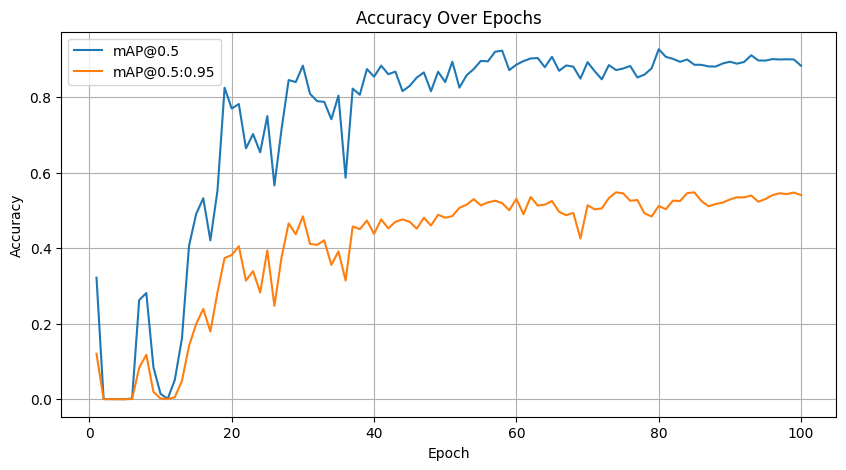

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [26]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 39.0ms
Speed: 0.6ms preprocess, 39.0ms inference, 10.7ms postprocess per image at shape (1, 3, 160, 320)


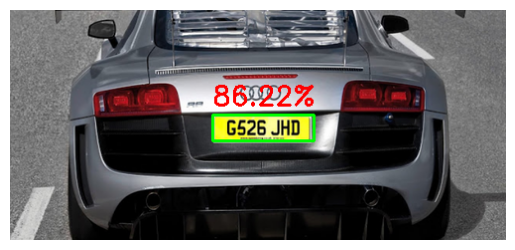

In [27]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 (no detections), 64.1ms
Speed: 0.8ms preprocess, 64.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


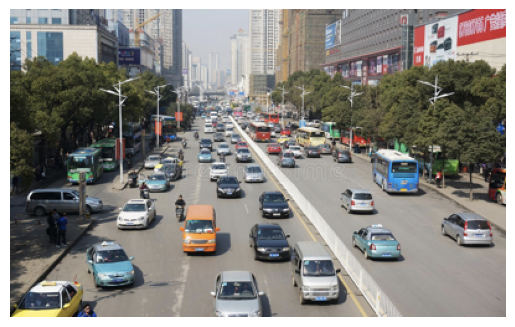

In [28]:
predict_and_plot(test.iloc[1].img_path)

In [30]:
!pip install paddleocr

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 107.1 MB/s eta 0:00:0000:010:01
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=6a47f3e97ecf390bf39d9e347462df0441ae831514e2d3eda0da271d4148564a
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling

In [32]:
!pip install paddlepaddle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 10.3 MB/s eta 0:00:0000:0100:01


In [33]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from paddleocr import PaddleOCR


# Initialize the PaddleOCR reader
ocr = PaddleOCR(use_angle_cls=True, lang='en')

def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text using PaddleOCR.
    
    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]
            
            # Convert the cropped ROI back to BGR (PaddleOCR works with OpenCV's format)
            roi_bgr = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)

            # Perform OCR on the cropped image using PaddleOCR
            ocr_result = ocr.ocr(roi_bgr)
            
            # Extract the detected text from the OCR result
            detected_text = " ".join([line[1][0] for line in ocr_result[0]])
            print(f"Detected text: {detected_text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:13<00:00, 281.38it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:10<00:00, 960.62it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:11<00:00, 189.76it/s]

[2024/11/30 13:04:41] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 57.1ms
Speed: 0.8ms preprocess, 57.1ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 320)
[2024/11/30 13:04:55] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09820127487182617
[2024/11/30 13:04:55] ppocr DEBUG: cls num  : 1, elapsed : 0.05078625679016113
[2024/11/30 13:04:55] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08855319023132324
Detected text: G526JHD


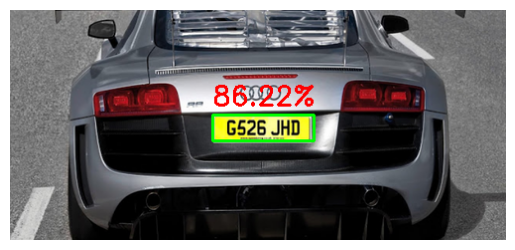

In [34]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 58.1ms
Speed: 0.8ms preprocess, 58.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 192)
[2024/11/30 13:05:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06985640525817871
[2024/11/30 13:05:02] ppocr DEBUG: cls num  : 1, elapsed : 0.016295909881591797
[2024/11/30 13:05:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06311607360839844
Detected text: JHI HAD


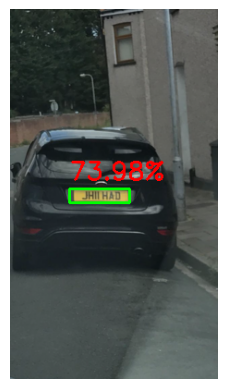

In [35]:
predict_and_plot(test.iloc[2].img_path)